In [46]:
# Load libraries
import numpy as np
from datetime import date
from pandas import read_csv, DataFrame
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from vectice import connect, FileDataWrapper, models, api, Model, DatasetSourceUsage



In [47]:
# Load dataset
url = "https://raw.githubusercontent.com/vectice/GettingStarted/main/22.4/tutorial/Data/iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = read_csv(url, names=names)

In [48]:
## Goal of this sample is to simply catalog assets in Vectice

# Connect to Vectice
conn = connect(
    api_token='ynqdogKBN.6mDRJXaMkGjrobPx0LwvEynqdogKBNl69e8VYZO2dQ3WA47pgz', 
    host='https://app.vectice.com',
    workspace='Samples'
)
# Get a list of available projects
# print(conn.projects)
project = conn.project(7207)

2023/01/18 10:43:44 INFO vectice.connection: Vectice successfully connected.
2023/01/18 10:43:44 WARNING vectice.connection: compatibility warning: Please upgrade to one of the Vectice SDK versions from 22.4.4.0 to 23.1.1 which are more compatible with your Vectice application.
2023/01/18 10:43:45 INFO vectice.connection: Your current workspace: Samples
2023/01/18 10:43:46 INFO vectice.connection: Assets with Latest Activity   Asset Type    Name
2023/01/18 10:43:46 INFO vectice.connection: Assets with Latest Activity   Project       'Simple project - Hello World'
2023/01/18 10:43:46 INFO vectice.connection: Assets with Latest Activity   Phase         'Model Iterations'
2023/01/18 10:43:46 INFO vectice.connection: Assets with Latest Activity   Iteration      50
2023/01/18 10:43:46 INFO vectice.connection: Assets with Latest Activity   Step          ''
2023/01/18 10:43:46 INFO vectice.models.workspace: Your current project: 7207


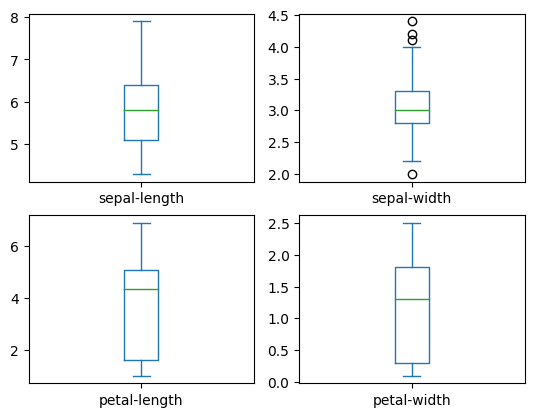

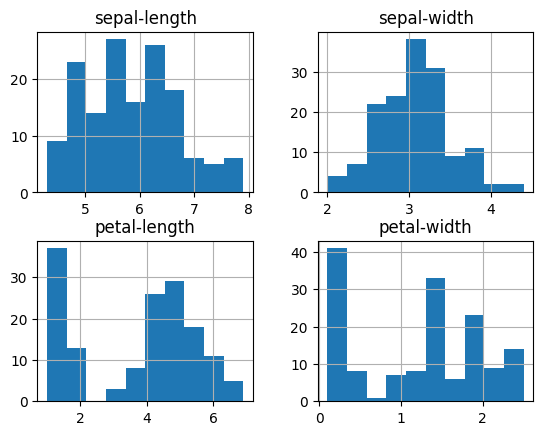

In [49]:
# Plot the dataset
dataset.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
boxplot = pyplot.savefig("boxplot.jpg")
pyplot.show()

# histograms
dataset.hist()
histogram = pyplot.savefig("histogram.jpg")
pyplot.show()

In [50]:
# Split-out validation dataset
array = dataset.values
X = array[:,0:4]
y = array[:,4]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

# Build Vectice objs

# Set the origin dataset for the project
project.origin_dataset = FileDataWrapper(path= 'iris.csv', name="Iris Dataset",capture_code=False)

# This dataset is now available for use as a Dataset Asset Widget in Vectice webapp

2023/01/18 10:43:55 INFO vectice.models.datasource.datawrapper.file_data_wrapper: File: iris.csv wrapped successfully.
2023/01/18 10:43:56 INFO vectice.api.client: Successfully registered Dataset(name='Iris Dataset', id=20252, version='Version 1', type=ORIGIN).
No phase has been selected in the session.


In [51]:
# I can define different usage for my datasets - TRAINING, TESTING, VALIDATION
#training_wrapped = FileDataWrapper(path="iris.csv", name="Training Dataset", usage=DatasetSourceUsage.TRAINING , capture_code=False)
#testing_wrapped = FileDataWrapper(path="iris.csv", name="Testing Dataset", usage=DatasetSourceUsage.TESTING, capture_code=False) #
#validation_wrapped = FileDataWrapper(path="iris3.csv", name="Validation Dataset", usage=DatasetSourceUsage.VALIDATION, capture_code=False)

# And attach them to the project/phase/iteration
#Phaseiter = project.phase("Modeling Techniques").iteration()
#Phaseiter.phase.clean_dataset = training_wrapped
#modelingDatasets = [training_wrapped, testing_wrapped, validation_wrapped]
#Phaseiter.modeling_dataset = modelingDatasets

In [52]:
# Spot Check Algorithms
models = []
models.append(('Logistic Regression', 'LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('Linear Discriminant Analysis', 'LDA', LinearDiscriminantAnalysis()))
models.append(('KNeighbors Classifier', 'KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier','CART',  DecisionTreeClassifier()))
models.append(('Gaussian NB', 'NB', GaussianNB()))
models.append(('Support Vector Classifier','SVM', SVC(gamma='auto')))

# evaluate each model in turn
results = []
names = []
labels = []
means = []
# Create a single iteration - One model - each version of it represents a model defined above
phaseIter = project.phase("Modeling Techniques").iteration()
iterStep = phaseIter.step("Build Model")
for name, label, model in models:
 kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
 scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}
 cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring)
 results.append(cv_results['test_acc'])
 means.append(np.mean(cv_results['test_acc']))
 labels.append(label)
 names.append(name)
 metrics = {"Accuracy Mean": cv_results['test_acc'].mean(), 
            "Accuracy Std.": cv_results['test_acc'].std(), 
            "Score Time Mean": cv_results['score_time'].mean(),
            "Score Time Std.": cv_results['score_time'].std()}
 # Document model in Vectice - 1 line
 iterStep.iteration.model = Model(name= 'Iris Classification Models_' + str(date.today()) , library= name, technique=name, metrics=metrics, attachments=['boxplot.jpg','histogram.jpg'], capture_code= True)
 # Document the associated dataset used
 iterStep.phase.clean_dataset = FileDataWrapper(path="iris.csv", name="Training Dataset", usage=DatasetSourceUsage.TRAINING , capture_code=False)
# Commit and close the iteration
winner = DataFrame({'label':names, 'value': means}).max()
iterStep.close(message="Iteration done\nThe model with the best accuracy mean is " + winner["label"] + ", with a mean accuracy value of: " + str(winner["value"]))


2023/01/18 10:43:57 INFO vectice.models.phase: Iteration with id: 3383 successfully retrieved.
2023/01/18 10:43:59 INFO vectice.models.iteration: Code captured and will be linked to asset.
2023/01/18 10:44:02 INFO vectice.models.iteration: Successfully registered Model(name='Iris Classification Models_2023-01-18', library='Logistic Regression', technique='Logistic Regression', version='Version 1').
2023/01/18 10:44:03 INFO vectice.models.iteration: Step: Build Model successfully retrieved.
2023/01/18 10:44:03 INFO vectice.models.iteration: Step: Build Model successfully retrieved.
2023/01/18 10:44:04 INFO vectice.models.iteration: Successfully added Model(name='Iris Classification Models_2023-01-18', version='Version 1') to Build Model
2023/01/18 10:44:04 INFO vectice.models.iteration: Successfully added Attachment: 30264 from Model(name='Iris Classification Models_2023-01-18', version='Version 1') to Build Model
2023/01/18 10:44:05 INFO vectice.models.iteration: Successfully added Att

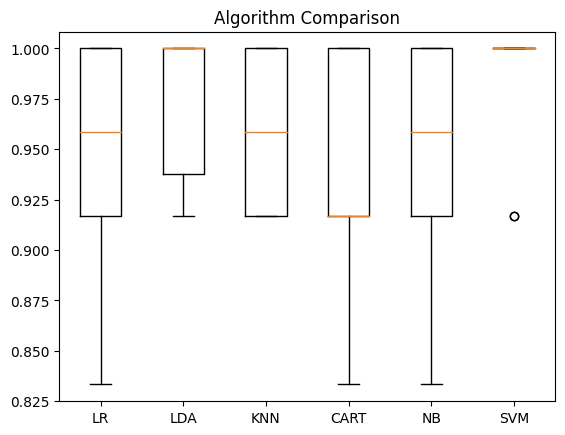

In [53]:
# Compare Algorithms
pyplot.boxplot(results, labels=labels)
pyplot.title('Algorithm Comparison')
pyplot.savefig("algComp.jpg")
pyplot.show()

In [54]:
# Based on the plot above it looks like SVM is getting us the most accurate results
# This has already been documented in Vectice in the previous cell whenclosing the iteration

# Let's get an understanding of the accuracy of our model using our validation dataset

# Make predictions on validation dataset
model = SVC(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

# Get the next phase in the Vectice project to document my iteration of the SVM model
phaseIter = project.phase("Model Iterations").iteration()
iterStep = phaseIter.step("Fine Tune Model")
metrics = {"Mean Accuracy": winner["value"]}
iterStep.iteration.model = Model(name= 'Iris Classification Models_' + winner["label"] , library= winner["label"], technique=winner["label"], metrics=metrics, attachments=['boxplot.jpg','histogram.jpg'], capture_code= True)
iterStep.close(message="Classification report:\n" + classification_report(Y_validation, predictions))

0.9666666666666667
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



2023/01/18 10:44:54 INFO vectice.models.phase: Iteration with id: 3384 successfully retrieved.
2023/01/18 10:44:56 WARNING vectice.models.iteration: The code commit exists already.
2023/01/18 10:44:59 INFO vectice.models.iteration: Successfully registered Model(name='Iris Classification Models_Support Vector Classifier', library='Support Vector Classifier', technique='Support Vector Classifier', version='Version 1').
2023/01/18 10:45:00 INFO vectice.models.iteration: Step: Fine Tune Model successfully retrieved.
2023/01/18 10:45:00 INFO vectice.models.iteration: Step: Fine Tune Model successfully retrieved.
2023/01/18 10:45:01 INFO vectice.models.iteration: Successfully added Model(name='Iris Classification Models_Support Vector Classifier', version='Version 1') to Fine Tune Model
2023/01/18 10:45:01 INFO vectice.models.iteration: Successfully added Attachment: 30276 from Model(name='Iris Classification Models_Support Vector Classifier', version='Version 1') to Fine Tune Model
2023/01/

In [55]:
# Fine tune the SVM model and check for improvement
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

param_grid = {'C':[0.1,1,10,100], 'gamma':[1,0.1,0.01,0.001]}
scoring = {
 'accuracy_score': make_scorer(accuracy_score)
}
grid = GridSearchCV(SVC(), param_grid, refit = 'accuracy_score', verbose=0)
grid.fit(X_train, Y_train)

pred_grid = grid.predict(X_validation)
tunedAccScore  = accuracy_score(Y_validation, pred_grid)
# Evaluate predictions
print(accuracy_score(Y_validation, pred_grid))
print(confusion_matrix(Y_validation, pred_grid))
print(classification_report(Y_validation, pred_grid))
# Document findings in Vectice
message = ""
mod = "base"
if winner["value"] > tunedAccScore:
    message += "The tuned model is less accurate than our base model."
elif winner == tunedAccScore:
    message += "The tuned model performs the same as the base model."
else:
    message += "The tuned model shows a relevant improvement over the base model"
    mod = "tuned"
message += "\nModel name: " + winner["label"] + "\nParameter grid:" + str(param_grid) + "\nBase model accuracy score:" + str(winner["value"]) + "\nTuned model accuracy score: " + str(tunedAccScore)
message += "\nRecommend deploying the {e} model." .format(e=mod)
phaseIter = project.phase("Model Iterations").iteration()
iterStep = phaseIter.step("Fine Tune Model")
metrics = {"Mean Accuracy": tunedAccScore}
iterStep.iteration.model = Model(name= 'Iris Classification Models_' + winner["label"] , library= winner["label"], technique=winner["label"], metrics=metrics, attachments=['boxplot.jpg','histogram.jpg'], capture_code= True)
iterStep.close(message=message)


0.9666666666666667
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



2023/01/18 10:45:04 INFO vectice.models.phase: Iteration with id: 3385 successfully retrieved.
2023/01/18 10:45:05 INFO vectice.models.iteration: Step: Fine Tune Model successfully retrieved.
2023/01/18 10:45:06 WARNING vectice.models.iteration: The code commit exists already.
2023/01/18 10:45:10 INFO vectice.models.iteration: Successfully registered Model(name='Iris Classification Models_Support Vector Classifier', library='Support Vector Classifier', technique='Support Vector Classifier', version='Version 2').
2023/01/18 10:45:10 INFO vectice.models.iteration: Model: Iris Classification Models_Support Vector Classifier already exists.
2023/01/18 10:45:11 INFO vectice.models.iteration: Step: Fine Tune Model successfully retrieved.
2023/01/18 10:45:12 INFO vectice.models.iteration: Step: Fine Tune Model successfully retrieved.
2023/01/18 10:45:12 INFO vectice.models.iteration: Successfully added Model(name='Iris Classification Models_Support Vector Classifier', version='Version 2') to 

### End of sample